In [5]:
import pickle
import numpy as np

rho=0.05
G = 0
with open("results/zeta_optim_hmm_12.pickle", "rb") as f:
    data:dict = pickle.load(f)
    p_vals = list(data[list(data.keys())[11]]["zeta"].values())
for i in range(len(p_vals)):
    area = np.pi * rho * (((i+1) * 10)**2 - (i*10)**2)
    G += rho * area * p_vals[i]

print(G)

0.04777344352226343


In [1]:
import numpy as np
import optuna
from functools import partial
import math
import pickle
import copy

from main_simulation import run_monte_carlo_simulation
from utils import SimulationParameters, overall_entropy
from environment import DTMC, NodeDistribution
from hmm_joint_prob import run_hmm_simulation

def objective(trial:optuna.Trial, params:SimulationParameters):
    local_params = copy.deepcopy(params)
    lower = 0
    upper = 5e-4
    value = trial.suggest_float("zeta_last", lower, upper)
    zeta = [upper]*(local_params.K-1)
    zeta.append(value)
    local_params.zeta = np.array(zeta)

    # using Monte Carlo simulation
    # entropy, _ = run_monte_carlo_simulation(local_params, 10000, 100, seed=0, zeta_bucket=True) # fix the seed to actually optimize the zeta

    # using formulas and averaging 10 different topologies
    #dtmc = DTMC(local_params.q, local_params.eta)
    NUM_RUNS = 15
    entropies = np.empty(NUM_RUNS, dtype=float)
    for j in range(NUM_RUNS):
        #node_dist = NodeDistribution(
        #    rho=local_params.rho,
        #    unit_radius=local_params.R_unit,
        #    K=local_params.K,
        #    zeta=zeta,
        #    alpha=local_params.alpha,
        #    beta=local_params.beta,
        #    seed=j,
        #    zeta_bucket=True,
        #    fixed_nodes_per_region=True
        #)
        # entropy, _ = run_monte_carlo_simulation(local_params, 10000, 100, seed=0, zeta_bucket=True) # fix the seed to actually optimize the zeta
        #entropy = overall_entropy(A=dtmc.A,
        #                          pi=dtmc.pi,
        #                          K=local_params.K,
        #                          R_unit=local_params.R_unit,
        #                          alpha=local_params.alpha,
        #                          m=len(node_dist),
        #                          zeta=node_dist.tx_probabilities,
        #                          epsilon=local_params.epsilon,
        #                          prob_per_bucket=zeta,
        #                          max_delta_considered=10000)
        _, entropy, _, _, _ = run_hmm_simulation(local_params, 10000, fixed_nodes_per_region=True, seed=j)
        entropies[j] = entropy
        trial.report(entropies[j], j)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(entropies)

if __name__ == "__main__":
    initial_params = SimulationParameters(
        q=0.005,
        eta=1,
        zeta=5e-4, # Example: list of base probabilities. NodeDistribution will use this.
        epsilon=0.1,
        rho=0.05,
        m_override=None,
        K=2, # Initial K for the first plot
        alpha=0.02,
        beta=0, # Default beta, will be overridden in the loop
        R_unit=10
    )
    initial_params.m = math.floor(initial_params.rho * np.pi * (initial_params.K*initial_params.R_unit)**2)
    wrapped_objective = partial(objective, params=initial_params)

    results = {}

    last_best_params = None
    for k in range(13, 15):
        current_params = copy.deepcopy(initial_params)
        current_params.K = k
        current_params.m = math.floor(current_params.rho * np.pi * (current_params.K*current_params.R_unit)**2)
        wrapped_objective = partial(objective, params=current_params)

        # call optuna
        study = optuna.create_study(direction="minimize", 
                                    #sampler=optuna.samplers.RandomSampler(), 
                                    pruner=optuna.pruners.MedianPruner()
                                    )
        # warm start the optimization
        values_to_try = [0, 5e-4, 5e-5, 5e-6, 5e-7, 5e-8, 5e-9]
        initial_guesses = {f"params_{n}": {f"zeta_last": val} for n, val in enumerate(values_to_try)}
        initial_guesses["last_best"] = last_best_params if last_best_params is not None else {f"zeta_{i}":9e-5 for i in range(k)}
        for params in initial_guesses.values():
            study.enqueue_trial(params)

        # start the optimization
        if k < 9:
            study.optimize(wrapped_objective, n_trials=200, n_jobs=2)
        else:
            study.optimize(wrapped_objective, n_trials=200, n_jobs=2)
        # compute the entropy for the fixed zeta case zeta = 1e-4
        if isinstance(initial_params.zeta, float):
            current_params.zeta = np.array([initial_params.zeta] * k)
        _, entropy, _, _, _ = run_hmm_simulation(current_params, 10000, seed=0, fixed_nodes_per_region=True)
        # get the best parameters and save them with the best objective
        results[k] = {"zeta": study.best_params,
                      "entropy_opt": study.best_value,
                      "entropy_same_z": entropy
                      }
        last_best_params = study.best_params
        last_best_params[f"zeta_{k}"] = 0
        
    print(results)

c:\ProgramData\mambaforge_24.3.0.0\envs\aoi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-25 14:57:02,446] A new study created in memory with name: no-name-8af0bbd7-6944-4a36-b8f1-b32f8363be87
[W 2025-07-25 14:57:02,490] Trial 1 failed with parameters: {'zeta_last': 0.0005} because of the following error: AssertionError().
Traceback (most recent call last):
  File "c:\ProgramData\mambaforge_24.3.0.0\envs\aoi\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\bura_al\AppData\Local\Temp\ipykernel_2520\688675601.py", line 52, in objective
    _, entropy, _, _, _ = run_hmm_simulation(local_params, 10000, fixed_nodes_per_region=True, seed=j)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

AssertionError: 

In [6]:
from utils import generate_lambda_matrix
import numpy as np

mat = generate_lambda_matrix(5, 10, 0.02, 10, "gaussian", base_sigma=0.05)
print(mat)
print(np.sum(mat, axis=1))
mat = generate_lambda_matrix(5, 10, 0.02, 10, "diagonal", base_sigma=0.05)
print(mat)

[[[1.00000000e+00 9.53168618e-01 9.40912559e-01 9.33603365e-01
   9.28389192e-01 9.24337586e-01 9.21025882e-01 9.18226494e-01
   9.15802806e-01 9.13666379e-01]
  [0.00000000e+00 4.68258304e-02 5.90728227e-02 6.63727857e-02
   7.15780037e-02 7.56210063e-02 7.89244554e-02 8.17159119e-02
   8.41319645e-02 8.62610275e-02]
  [0.00000000e+00 5.55178635e-06 1.46185096e-05 2.38491528e-05
   3.28040979e-05 4.14074007e-05 4.96627624e-05 5.75939768e-05
   6.52286228e-05 7.25931391e-05]
  [0.00000000e+00 1.58858884e-12 1.42592074e-11 4.33122896e-11
   8.93666809e-11 1.51752958e-10 2.29471984e-10 3.21485306e-10
   4.26808940e-10 5.44540885e-10]
  [0.00000000e+00 1.09703826e-21 5.48232262e-20 3.97561758e-19
   1.44717873e-18 3.72237428e-18 7.78588504e-18 1.42121182e-17
   2.35693131e-17 3.64098907e-17]]

 [[0.00000000e+00 4.47312523e-02 5.57778666e-02 6.22416350e-02
   6.67968206e-02 7.03045086e-02 7.31510487e-02 7.55428583e-02
   7.76030661e-02 7.94109568e-02]
  [1.00000000e+00 9.10532192e-01 8.884

  0%|          | 0/16 [00:00<?, ?it/s]

Uniforme


  6%|▋         | 1/16 [00:05<01:22,  5.53s/it]




 Gaussiana
Entropy unif: 0.443452081119806
Entropy gaus: 0.5291153568401387
Uniforme


 12%|█▎        | 2/16 [00:10<01:16,  5.44s/it]




 Gaussiana
Entropy unif: 0.34018956979576226
Entropy gaus: 0.4415391145628974
Uniforme


 19%|█▉        | 3/16 [00:16<01:10,  5.45s/it]




 Gaussiana
Entropy unif: 0.26841916341451677
Entropy gaus: 0.36001883529210815
Uniforme


 25%|██▌       | 4/16 [00:21<01:05,  5.45s/it]




 Gaussiana
Entropy unif: 0.2181812283951503
Entropy gaus: 0.30625143168754376
Uniforme


 31%|███▏      | 5/16 [00:27<01:00,  5.47s/it]




 Gaussiana
Entropy unif: 0.19101412885930955
Entropy gaus: 0.2719017709981576
Uniforme


 38%|███▊      | 6/16 [00:32<00:54,  5.50s/it]




 Gaussiana
Entropy unif: 0.18034952741747726
Entropy gaus: 0.26009103157262287
Uniforme


 44%|████▍     | 7/16 [00:38<00:49,  5.54s/it]




 Gaussiana
Entropy unif: 0.16252573705342194
Entropy gaus: 0.25204276192755243
Uniforme


 50%|█████     | 8/16 [00:44<00:44,  5.58s/it]




 Gaussiana
Entropy unif: 0.15984008145565326
Entropy gaus: 0.2516483188096718
Uniforme


 56%|█████▋    | 9/16 [00:49<00:39,  5.63s/it]




 Gaussiana
Entropy unif: 0.15749227911424876
Entropy gaus: 0.2339025746150314
Uniforme


 62%|██████▎   | 10/16 [00:55<00:33,  5.67s/it]




 Gaussiana
Entropy unif: 0.15895670548875104
Entropy gaus: 0.2322517731409284
Uniforme


 69%|██████▉   | 11/16 [01:01<00:28,  5.70s/it]




 Gaussiana
Entropy unif: 0.16242886122515204
Entropy gaus: 0.24165297812368433
Uniforme


 75%|███████▌  | 12/16 [01:07<00:22,  5.73s/it]




 Gaussiana
Entropy unif: 0.17736941582246463
Entropy gaus: 0.26902222148529964
Uniforme


 81%|████████▏ | 13/16 [01:13<00:17,  5.77s/it]




 Gaussiana
Entropy unif: 0.20186419709976258
Entropy gaus: 0.286986023861849
Uniforme


 88%|████████▊ | 14/16 [01:18<00:11,  5.78s/it]




 Gaussiana
Entropy unif: 0.22489405990560313
Entropy gaus: 0.3202796397005552
Uniforme


 94%|█████████▍| 15/16 [01:24<00:05,  5.80s/it]




 Gaussiana
Entropy unif: 0.2509331873414848
Entropy gaus: 0.36138241524818554
Uniforme


100%|██████████| 16/16 [01:30<00:00,  5.66s/it]




 Gaussiana
Entropy unif: 0.28626679775250835
Entropy gaus: 0.3882352796162966


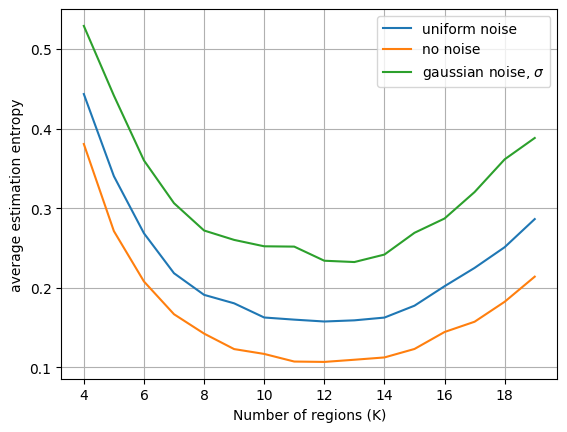

ValueError: x and y must have same first dimension, but have shapes (16,) and (0,)

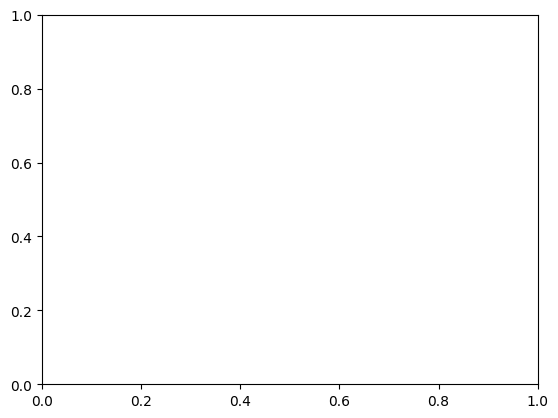

In [7]:
from hmm_joint_prob import run_hmm_simulation, run_hmm_simulation
from utils import SimulationParameters

from tqdm import tqdm
from copy import deepcopy
import math
import numpy as np

uniform_params = SimulationParameters(
        q=0.005,
        eta=1,
        zeta=5e-4, # Example: list of base probabilities. NodeDistribution will use this.
        epsilon=0.1,
        rho=0.05,
        m_override=None,
        K=2, # Initial K for the first plot
        alpha=0.02,
        beta=0, # Default beta, will be overridden in the loop
        R_unit=10,
        X_symbols=[i for i in range(10)],
        Y_symbols=[i for i in range(11)],
    )

import matplotlib.pyplot as plt
avg_unif, avg_gau_large, avg_gau_thin = [], [], []
avg_test = []
loc_aware_multi, loc_aware_bin = [], []
sim_length =10000
min_k = 4
for k in tqdm(range(min_k,20)):
    uniform_params.K = k
    uniform_params.m = math.floor(uniform_params.rho * np.pi * (uniform_params.K*uniform_params.R_unit)**2)
    test_params = deepcopy(uniform_params)
    test_params.noise_distribution = "diagonal"
    gaussian_params_1 = deepcopy(uniform_params)
    gaussian_params_1.noise_distribution = "gaussian"
    gaussian_params_1.base_sigma = 6

    print("Uniforme")
    entropy_evol_unif, avg_entropy_unif, _, _, _ = run_hmm_simulation(uniform_params, sim_length, seed=0, non_binary=True)
    entropy_evol_diag, avg_entropy_test, _, _, _ = run_hmm_simulation(test_params, sim_length, seed=0, non_binary=True)
    _, avg_entropy_gau_1, _, _, _ = run_hmm_simulation(gaussian_params_1, sim_length, seed=0, non_binary=True)
    print("\n\n\n Gaussiana")

    bin_params = deepcopy(uniform_params)
    bin_params.X_symbols = [0,1]
    bin_params.Y_symbols = [i for i in range(len(bin_params.X_symbols) * k + 1)]
    multi_params = deepcopy(uniform_params)
    multi_params.Y_symbols = [i for i in range(len(multi_params.X_symbols) * k + 1)]
    #_, avg_entropy_bin, _, _, _ = run_hmm_simulation(bin_params, sim_length, seed=0, non_binary=False, loc_aware=True)
    #_, avg_entropy_multi, _, _, _ = run_hmm_simulation(multi_params, sim_length, seed=0, non_binary=True, loc_aware=True)

    print(f"Entropy unif: {avg_entropy_unif}")
    print(f"Entropy gaus: {avg_entropy_gau_1}")
    avg_unif.append(avg_entropy_unif)
    avg_test.append(avg_entropy_test)
    avg_gau_large.append(avg_entropy_gau_1)

    #loc_aware_bin.append(avg_entropy_bin)
    #loc_aware_multi.append(avg_entropy_multi)

    #plt.semilogy(entropy_evol_unif, label="entropy unif")
    #plt.plot(entropy_evol_unif, label="entropy unif")
    #plt.legend()
    #plt.show()

plt.figure(0)
plt.plot(np.arange(min_k, 20), avg_unif, label="uniform noise")
plt.plot(np.arange(min_k, 20), avg_test, label="no noise")
plt.plot(np.arange(min_k, 20), avg_gau_large, label=r"gaussian noise, $\sigma$")
plt.legend()
plt.xlabel("Number of regions (K)")
plt.ylabel("average estimation entropy")
plt.grid(True)
plt.show()

plt.figure(1)

plt.plot(np.arange(min_k, 20), loc_aware_bin, label="2 symbols loc aware")
plt.plot(np.arange(min_k, 20), loc_aware_multi, label="6 symbols loc aware")
plt.plot(np.arange(min_k, 20), avg_unif, linestyle=":", label="6 symbols")
plt.xlabel("Number of regions (K)")
plt.ylabel("average estimation entropy")
plt.grid(True)
plt.legend()
plt.show()



In [5]:
p = np.array([0.9,0.05,0.05])
p2 = np.array([0.9,0.025,0.025,0.025,0.025])

print(f"Entropy p: {-np.sum(p*np.log2(p))}")
print(f"Entropy p2: {-np.sum(p2*np.log2(p2))}")

Entropy p: 0.5689955935892812
Entropy p2: 0.6689955935892812


[1.         0.89595846 0.85133992 0.82317125 0.80274156 0.78679344
 0.77375891 0.76276521 0.75327769 0.74494574 0.73752725 0.73084826
 0.72477966 0.71922309 0.71410192 0.70935532 0.70493424 0.70079855
 0.69691502 0.69325584 0.6897975  0.68651994 0.68340594 0.68044059
 0.67761091 0.67490552 0.6723144  0.66982867 0.66744044 0.66514265
 0.662929   0.66079378 0.65873185 0.65673857 0.65480968 0.65294134
 0.65113001 0.64937247 0.64766574 0.6460071  0.64439401 0.64282416
 0.64129537 0.63980566 0.63835314 0.63693609 0.6355529  0.63420205
 0.63288212 0.6315918 ]


C:\Users\bura_al\AppData\Local\Temp\ipykernel_11892\2329785688.py:7: RuntimeWarning: divide by zero encountered in divide
  sigma = np.sqrt(1/2*1/np.log(lam/(1-lam)))
C:\Users\bura_al\AppData\Local\Temp\ipykernel_11892\2329785688.py:8: RuntimeWarning: divide by zero encountered in divide
  prob_eq = 1/(1+np.exp(-1/(2*sigma**2)))


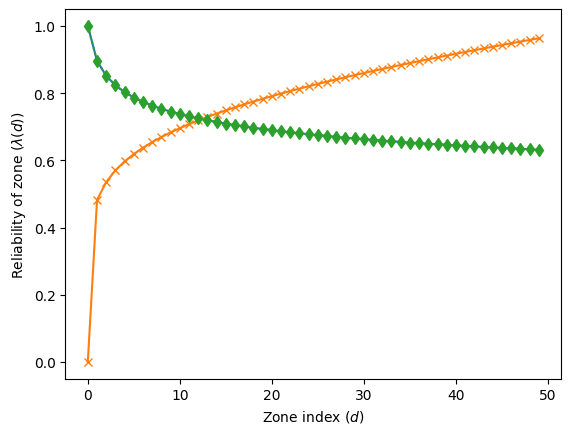

In [5]:
import numpy as np
R=2
K=50
alpha=0.1
lam = [1/(1+d*R)**alpha for d in range(0,K)]
lam = np.array(lam)
sigma = np.sqrt(1/2*1/np.log(lam/(1-lam)))
prob_eq = 1/(1+np.exp(-1/(2*sigma**2)))

#gaussian


import matplotlib.pyplot as plt
print(lam)

plt.plot(lam, marker = '.')
plt.plot(sigma, marker='x')
plt.plot(prob_eq, marker='d', linestyle=':')
plt.ylabel(r"Reliability of zone ($\lambda(d)$)")
plt.xlabel(r"Zone index ($d$)")
plt.show()

P(0) = 0.5703
P(1) = 0.3459
P(2) = 0.0772
P(3) = 0.0063
P(4) = 0.0002


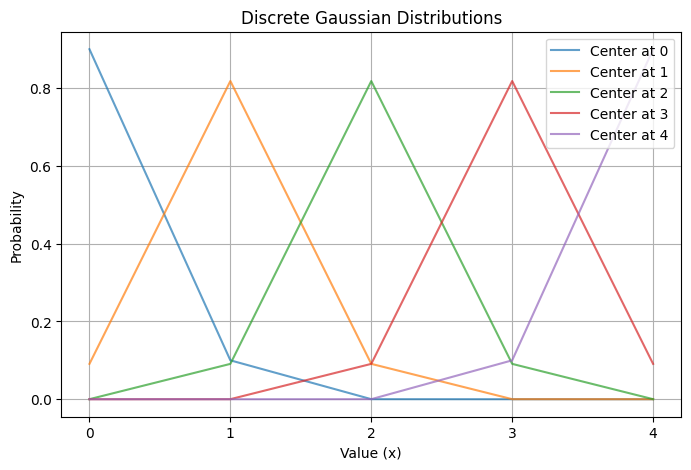

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the discrete set of values
x_values = np.arange(0, 5)  # From -5 to 5

# Mean and standard deviation for the Gaussian distribution
mu = 0
sigma = 1

def _compute_sigma(lam_val:float) -> np.ndarray:
    if np.isclose(lam_val, 1):
        return 0
    sigma = np.sqrt(1/2*1/np.log(lam_val/(1-lam_val)))
    return sigma

def _gaussian_split_with_center_non_symmetric(domain:np.ndarray, center_value:int, sigma:float) -> np.ndarray:
    # Find the index of the center value in the domain
    center_index = np.where(domain == center_value)[0][0]

    if np.isclose(sigma, 0):
        out = np.zeros(len(domain))
        out[center_index] = 1
        return out
    
    # Calculate Gaussian values for all points relative to the chosen center
    distances = domain - domain[center_index]
    gaussian_vals = np.exp(- (distances**2) / (2 * sigma**2))
    
    # Normalize the rest so sum to 1
    gaussian_rest_norm = gaussian_vals/ np.sum(gaussian_vals)#gaussian_vals_without_center / gaussian_vals_without_center.sum()

    # Allocate probabilities
    probs = gaussian_rest_norm
    
    return probs

# Calculate the Gaussian probability for each x
raw_probabilities = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x_values - mu)**2 / (2 * sigma**2))

# Normalize the probabilities so that they sum to 1
normalized_probabilities = raw_probabilities / np.sum(raw_probabilities)

# Display the probabilities
for x, p in zip(x_values, normalized_probabilities):
    print(f"P({x}) = {p:.4f}")

# Plot the probability distributions for all possible centers
lam_val = 0.9
sigma = _compute_sigma(lam_val)

plt.figure(figsize=(8, 5))
for center in x_values:
    shifted_probs = _gaussian_split_with_center_non_symmetric(x_values, center, sigma)
    plt.plot(x_values, shifted_probs, label=f'Center at {center}', alpha=0.7)
plt.title("Discrete Gaussian Distributions")
plt.xticks(x_values, [str(x) for x in x_values])
plt.xlabel("Value (x)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
#plt.stem(x_values, normalized_probabilities)
#plt.title("Discrete Gaussian Probability Distribution")
#plt.xlabel("Value (x)")
#plt.ylabel("Probability")
#plt.show()

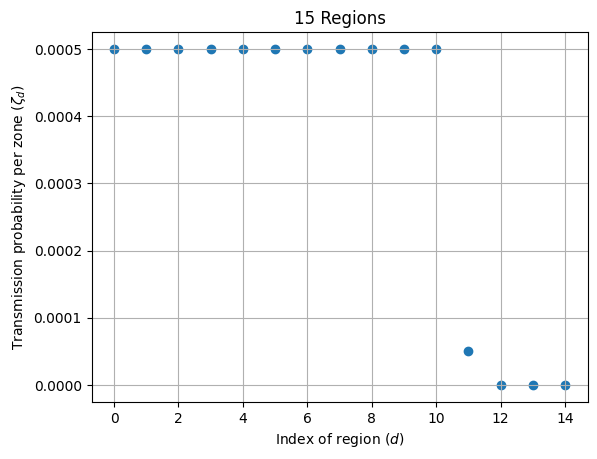

In [11]:
import matplotlib.pyplot as plt
import numpy as np

xs = np.arange(0,15)

probs = [5e-4]*11 + [5e-5] +[0]*3
plt.scatter(xs, probs)
plt.grid(True)
plt.ylabel(r"Transmission probability per zone ($\zeta_d$)")
plt.xlabel(r"Index of region ($d$)")
plt.title("15 Regions")
plt.show()

Found 6 possible vehicle orderings. Solving for each...

--- Solving for Order 1/6: (0, 1, 2) ---
Status: Optimal
Optimal Objective Value: 16.86


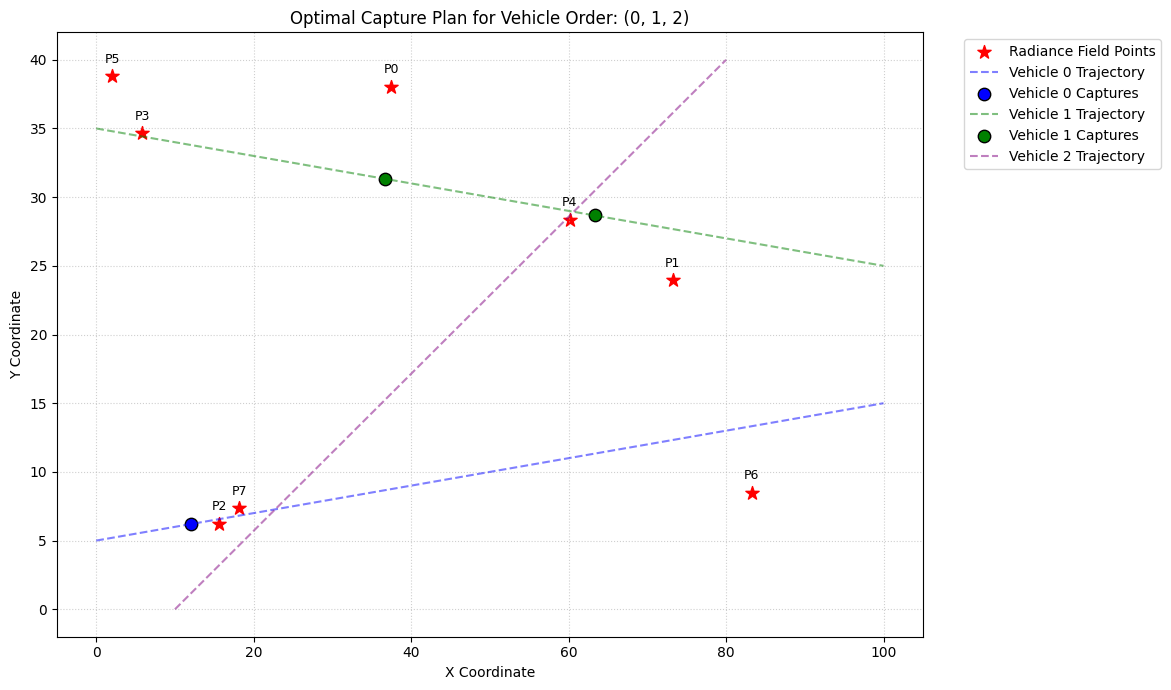


--- Solving for Order 2/6: (0, 2, 1) ---
Status: Optimal
Optimal Objective Value: 18.24


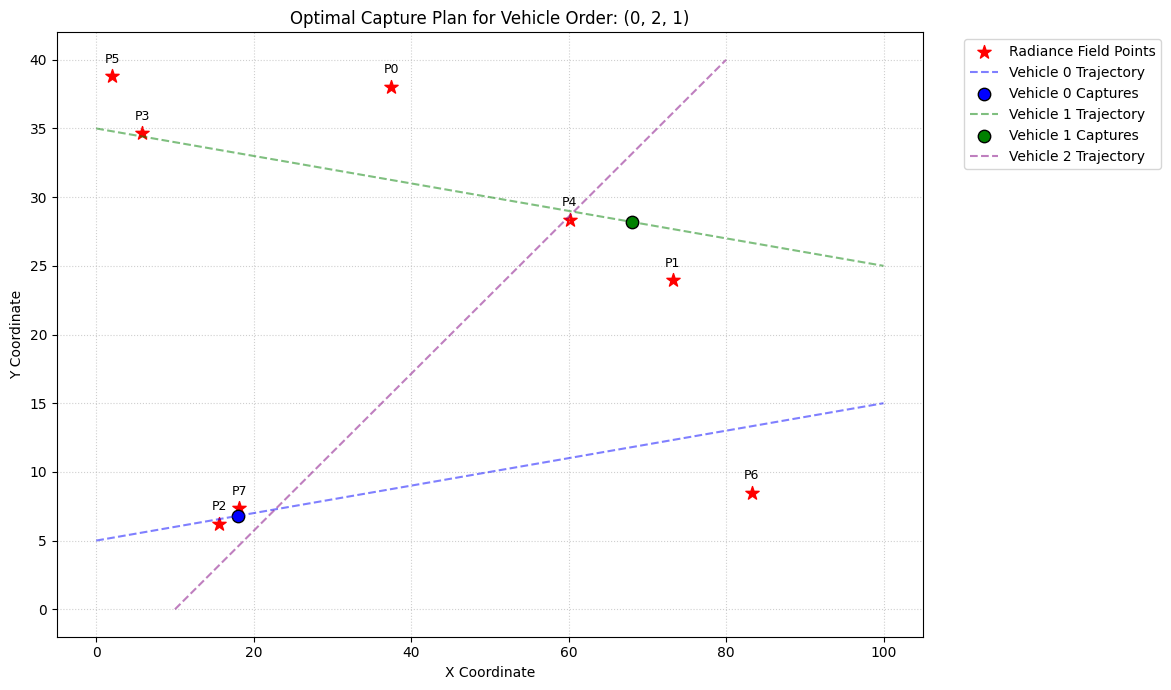


--- Solving for Order 3/6: (1, 0, 2) ---
Status: Optimal
Optimal Objective Value: 15.39


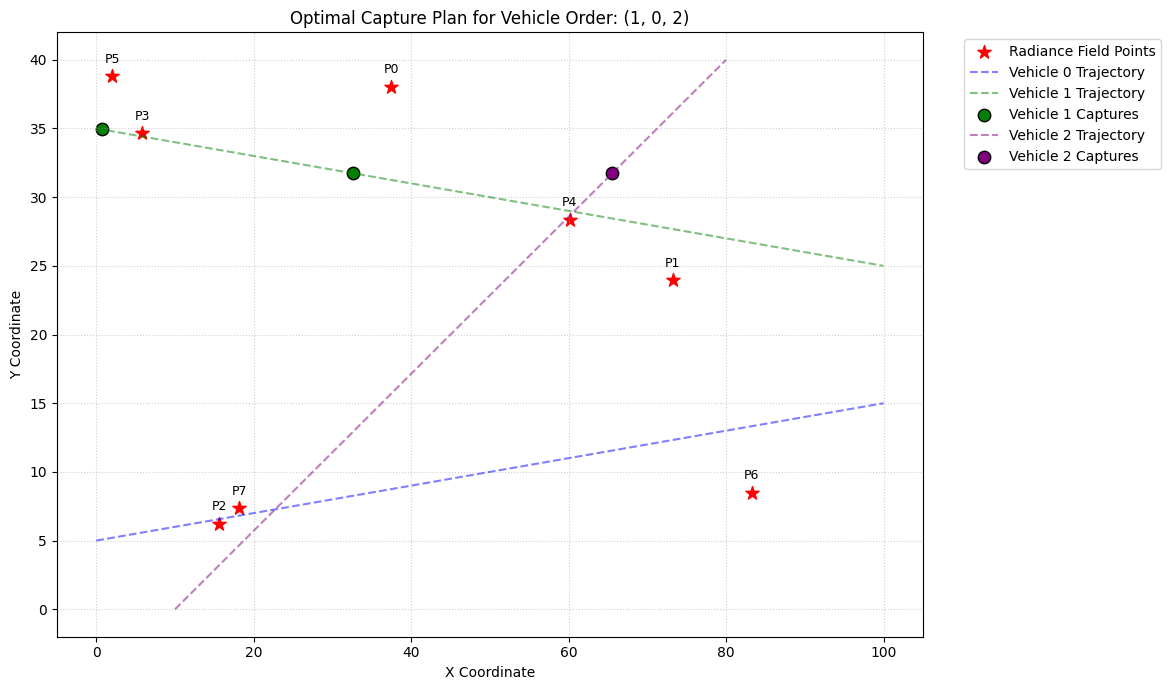


--- Solving for Order 4/6: (1, 2, 0) ---
Status: Optimal
Optimal Objective Value: 17.06


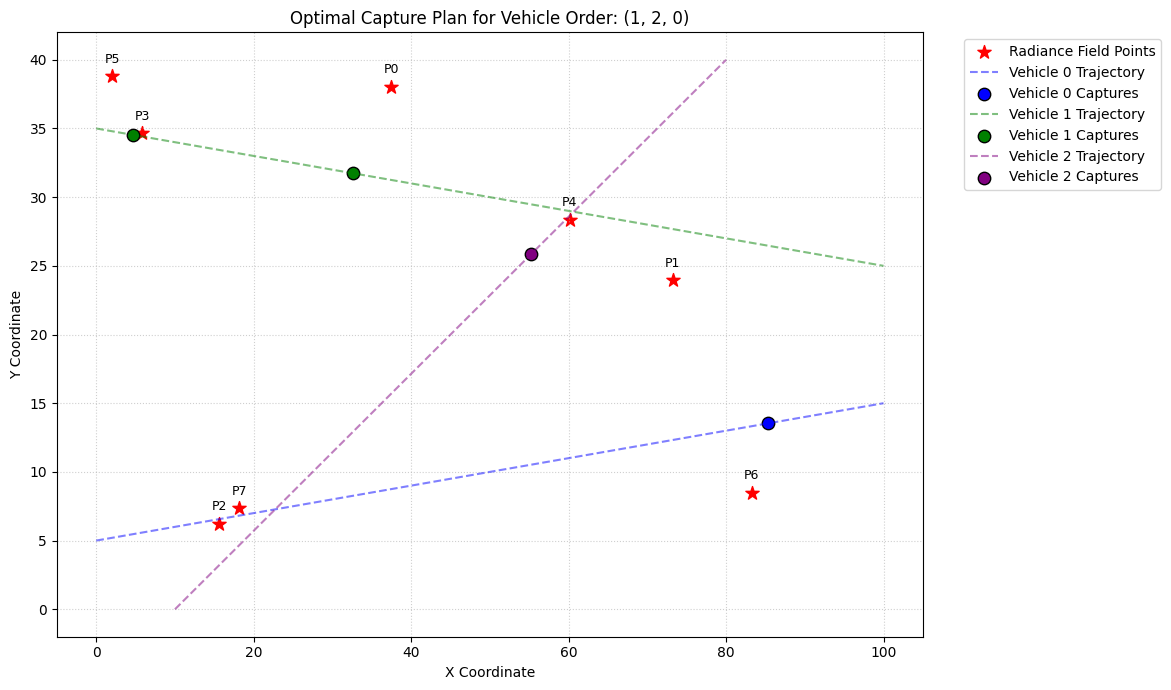


--- Solving for Order 5/6: (2, 0, 1) ---
Status: Optimal
Optimal Objective Value: 18.24


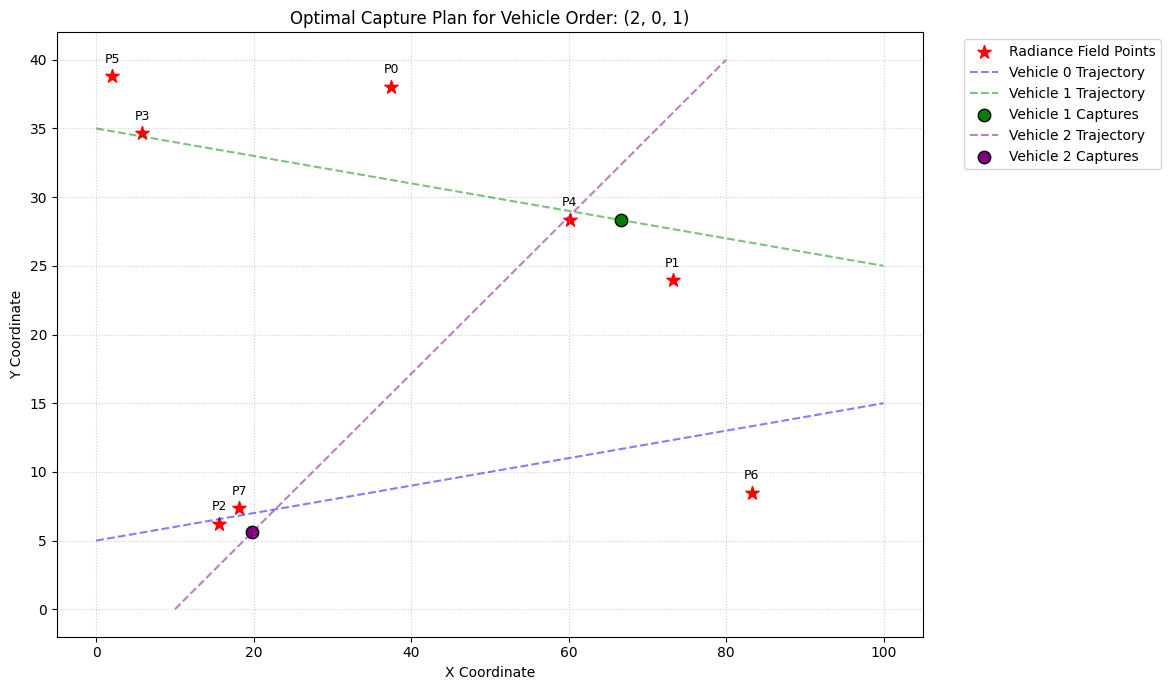


--- Solving for Order 6/6: (2, 1, 0) ---
Status: Optimal
Optimal Objective Value: 18.53


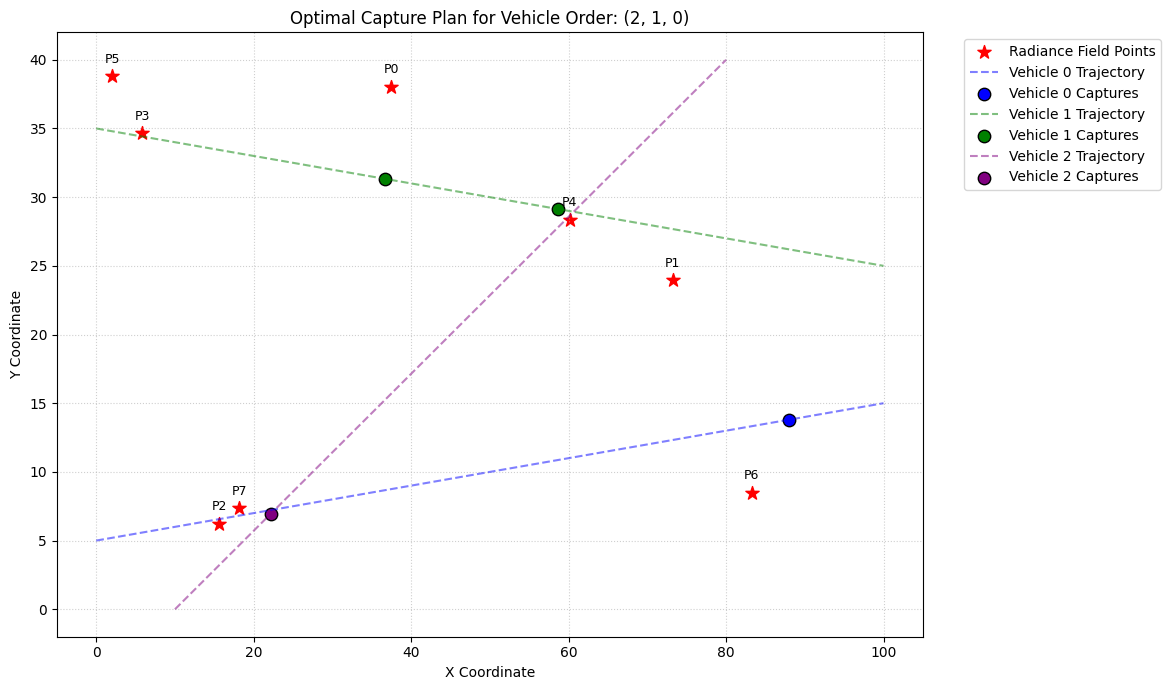

In [2]:
import pulp
import matplotlib.pyplot as plt
import numpy as np
import itertools

# --- 1. Problem Definition and Data ---

# General Parameters
N_VEHICLES = 3
N_POINTS = 8
TOTAL_TIME_STEPS = 150
CAPTURE_DISTANCE_THRESHOLD = 8.0

# Define vehicles
vehicles = list(range(N_VEHICLES))

# Define radiance field points of interest
np.random.seed(42)
points_pos = {p: (np.random.uniform(0, 100), np.random.uniform(0, 40)) for p in range(N_POINTS)}
points_weights = {p: np.random.uniform(1, 5) for p in range(N_POINTS)}

# Define vehicle trajectories (start and end points for straight lines)
vehicle_trajectories = {
    0: {'start': (0, 5), 'end': (100, 15)},
    1: {'start': (0, 35), 'end': (100, 25)},
    2: {'start': (10, 0), 'end': (80, 40)}
}

# Define vehicle-specific parameters
F_max = {v: 5 for v in vehicles} # Max captures per vehicle
R_reward = {v: 0.5 for v in vehicles} # Reward for unused captures

# --- 2. Helper Functions ---

def get_vehicle_position(v, t):
    """Calculates vehicle position at time t along its straight path."""
    start = np.array(vehicle_trajectories[v]['start'])
    end = np.array(vehicle_trajectories[v]['end'])
    # Assumes vehicle travels from start to end in TOTAL_TIME_STEPS
    return start + (end - start) * (t / TOTAL_TIME_STEPS)

# Pre-calculate all vehicle positions
vehicle_positions = {
    (v, t): get_vehicle_position(v, t)
    for v in vehicles for t in range(TOTAL_TIME_STEPS + 1)
}

def calculate_distance(pos1, pos2):
    """Calculates Euclidean distance between two points."""
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

# --- 3. Main Loop for All Vehicle Order Permutations ---

vehicle_order_permutations = list(itertools.permutations(vehicles))
print(f"Found {len(vehicle_order_permutations)} possible vehicle orderings. Solving for each...")

for i, vehicle_order in enumerate(vehicle_order_permutations):
    print(f"\n--- Solving for Order {i+1}/{len(vehicle_order_permutations)}: {vehicle_order} ---")

    # Define time windows based on the current vehicle order
    steps_per_vehicle = TOTAL_TIME_STEPS // N_VEHICLES
    time_windows = {}
    for idx, v_id in enumerate(vehicle_order):
        start_time = idx * steps_per_vehicle
        end_time = start_time + steps_per_vehicle
        time_windows[v_id] = list(range(start_time, end_time))

    # Pre-calculate the 'd' parameter: 1 if vehicle v is close to point p at time t
    d_param = {
        (p, v, t): 1 if calculate_distance(vehicle_positions[v, t], points_pos[p]) <= CAPTURE_DISTANCE_THRESHOLD else 0
        for p in points_pos for v in vehicles for t in time_windows[v]
    }

    # --- 4. Optimization Model using PuLP ---

    # Create the problem
    prob = pulp.LpProblem(f"VehicleImageCapture_Order_{i+1}", pulp.LpMaximize)

    # Decision Variables
    c_vars = pulp.LpVariable.dicts("c",
                                   ((v, t) for v in vehicles for t in time_windows[v]),
                                   cat='Binary')
    y_vars = pulp.LpVariable.dicts("y", (points_pos.keys()), cat='Binary')

    # Objective Function
    value_of_coverage = pulp.lpSum(points_weights[p] * y_vars[p] for p in points_pos)
    reward_for_saving = pulp.lpSum(R_reward[v] * (F_max[v] - pulp.lpSum(c_vars[v, t] for t in time_windows[v])) for v in vehicles)
    prob += value_of_coverage + reward_for_saving

    # Constraints
    # 1. Max capture frequency
    for v in vehicles:
        prob += pulp.lpSum(c_vars[v, t] for t in time_windows[v]) <= F_max[v], f"Max_Captures_v{v}"

    # 2. Point coverage linking
    for p in points_pos:
        prob += pulp.lpSum(d_param[p, v, t] * c_vars[v, t] for v in vehicles for t in time_windows[v] if (p,v,t) in d_param) >= y_vars[p], f"Link_y_p{p}"

    # 3. Promote diversity (optional but good practice)
    for p in points_pos:
         prob += pulp.lpSum(d_param[p, v, t] * c_vars[v, t] for v in vehicles for t in time_windows[v] if (p,v,t) in d_param) <= 1, f"Diversity_p{p}"

    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0)) # msg=0 suppresses solver output

    # --- 5. Visualization of the Results ---
    print(f"Status: {pulp.LpStatus[prob.status]}")
    if prob.status == pulp.LpStatusOptimal:
        print(f"Optimal Objective Value: {pulp.value(prob.objective):.2f}")
        
        plt.figure(figsize=(14, 7))
        
        # Plot radiance field points
        plt.scatter([pos[0] for pos in points_pos.values()],
                    [pos[1] for pos in points_pos.values()],
                    s=100, c='red', marker='*', label='Radiance Field Points')
        for p, pos in points_pos.items():
            plt.text(pos[0], pos[1] + 1, f'P{p}', fontsize=9, ha='center')

        # Plot vehicle trajectories and captures
        colors = ['blue', 'green', 'purple', 'orange']
        for v in vehicles:
            # Full trajectory line
            path = np.array([vehicle_positions[v, t] for t in range(TOTAL_TIME_STEPS + 1)])
            plt.plot(path[:, 0], path[:, 1], '--', color=colors[v % len(colors)], alpha=0.5, label=f'Vehicle {v} Trajectory')

            # Capture instants
            capture_points_x = []
            capture_points_y = []
            for t in time_windows[v]:
                if pulp.value(c_vars[v, t]) == 1:
                    pos = vehicle_positions[v, t]
                    capture_points_x.append(pos[0])
                    capture_points_y.append(pos[1])
            
            if capture_points_x:
                plt.scatter(capture_points_x, capture_points_y, s=80,
                            color=colors[v % len(colors)], marker='o', edgecolor='black',
                            label=f'Vehicle {v} Captures')

        plt.title(f'Optimal Capture Plan for Vehicle Order: {vehicle_order}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

--- Starting Constraint-Aware Genetic Algorithm ---
Generation  1/50 | Best Fitness So Far: 83.82
Generation  2/50 | Best Fitness So Far: 83.82
Generation  3/50 | Best Fitness So Far: 83.82
Generation  4/50 | Best Fitness So Far: 83.82
Generation  5/50 | Best Fitness So Far: 83.82
Generation  6/50 | Best Fitness So Far: 83.82
Generation  7/50 | Best Fitness So Far: 83.82
Generation  8/50 | Best Fitness So Far: 83.82
Generation  9/50 | Best Fitness So Far: 83.82
Generation 10/50 | Best Fitness So Far: 83.82
Generation 11/50 | Best Fitness So Far: 83.82
Generation 12/50 | Best Fitness So Far: 83.82
Generation 13/50 | Best Fitness So Far: 83.82
Generation 14/50 | Best Fitness So Far: 83.82
Generation 15/50 | Best Fitness So Far: 83.82
Generation 16/50 | Best Fitness So Far: 83.82
Generation 17/50 | Best Fitness So Far: 83.82
Generation 18/50 | Best Fitness So Far: 83.82
Generation 19/50 | Best Fitness So Far: 83.82
Generation 20/50 | Best Fitness So Far: 83.82
Generation 21/50 | Best Fitn

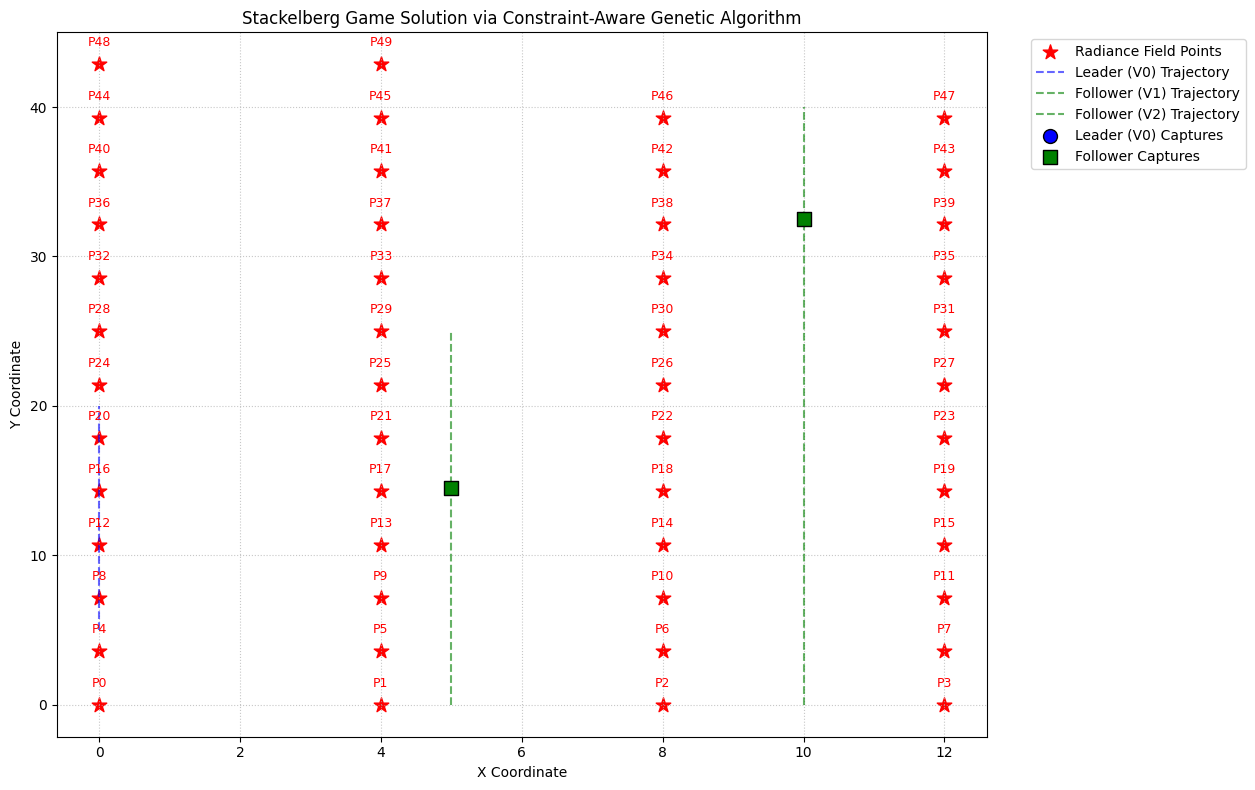

In [3]:
import pulp
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

# --- 1. Problem Definition and Data (Unchanged) ---
N_VEHICLES = 3
N_POINTS = 50
TOTAL_TIME_STEPS = 150
CAPTURE_DISTANCE_THRESHOLD = 8.0
LEADER_ID = 0
all_vehicles = list(range(N_VEHICLES))
followers = [v for v in all_vehicles if v != LEADER_ID]
np.random.seed(42)
# Place points in an equi-spaced grid within the 0-100 x 0-40 area
width = 12
length = 50
grid_rows = int(np.ceil(np.sqrt(N_POINTS * length / width)))
grid_cols = int(np.ceil(N_POINTS / grid_rows))
x_vals = np.linspace(0, width, grid_cols)
y_vals = np.linspace(0, length, grid_rows)
points_pos = {}
idx = 0
for y in y_vals:
    for x in x_vals:
        if idx < N_POINTS:
            points_pos[idx] = (x, y)
            idx += 1
points_weights = {p: np.random.uniform(1, 5) for p in range(N_POINTS)}
vehicle_trajectories = {
    0: {'start': (0, 5), 'end': (0, 20)},
    1: {'start': (5, 0), 'end': (5, 25)},
    2: {'start': (10, 0), 'end': (10, 40)}
}
F_max = {v: 5 for v in all_vehicles}
R_reward = {v: 0.5 for v in all_vehicles}
steps_per_vehicle = TOTAL_TIME_STEPS // N_VEHICLES
time_windows = {}
vehicle_order = [LEADER_ID] + followers
for idx, v_id in enumerate(vehicle_order):
    start_time = idx * steps_per_vehicle
    end_time = start_time + steps_per_vehicle
    time_windows[v_id] = list(range(start_time, end_time))

def get_vehicle_position(v, t):
    start, end = np.array(vehicle_trajectories[v]['start']), np.array(vehicle_trajectories[v]['end'])
    return start + (end - start) * (t / TOTAL_TIME_STEPS)

vehicle_positions = {(v, t): get_vehicle_position(v, t) for v in all_vehicles for t in range(TOTAL_TIME_STEPS + 1)}

def calculate_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

d_param = {
    (p, v, t): 1 if calculate_distance(vehicle_positions[v, t], points_pos[p]) <= CAPTURE_DISTANCE_THRESHOLD else 0
    for p in points_pos for v in all_vehicles for t in time_windows.get(v, [])
}

# --- 2. Lower-Level Problem: Follower's Optimal Response Solver (Unchanged) ---
def solve_followers_problem(leader_captures_plan):
    points_covered_by_leader = {p: 0 for p in points_pos}
    for p in points_pos:
        for t, was_captured in leader_captures_plan.items():
            if was_captured and d_param.get((p, LEADER_ID, t), 0) == 1:
                points_covered_by_leader[p] = 1
                break
    prob = pulp.LpProblem("Followers_Response_Problem", pulp.LpMaximize)
    c_f = pulp.LpVariable.dicts("c_follower", ((v, t) for v in followers for t in time_windows[v]), cat='Binary')
    y_total = pulp.LpVariable.dicts("y_total_coverage", points_pos.keys(), cat='Binary')
    followers_coverage_value = pulp.lpSum(points_weights[p] * y_total[p] for p in points_pos)
    followers_capture_reward = pulp.lpSum(R_reward[v] * (F_max[v] - pulp.lpSum(c_f[v, t] for t in time_windows[v])) for v in followers)
    prob += followers_coverage_value + followers_capture_reward
    for v in followers:
        prob += pulp.lpSum(c_f[v, t] for t in time_windows[v]) <= F_max[v], f"Follower_Max_Captures_v{v}"
    for p in points_pos:
        follower_captures_of_p = pulp.lpSum(d_param[p, v, t] * c_f[v, t] for v in followers for t in time_windows[v])
        prob += points_covered_by_leader[p] + follower_captures_of_p >= y_total[p], f"Total_Coverage_p{p}"
        prob += points_covered_by_leader[p] + follower_captures_of_p <= 1, f"Total_Diversity_p{p}"
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    followers_actions = {key: int(pulp.value(var)) for key, var in c_f.items()}
    total_y_coverage = {p: int(pulp.value(y_total[p])) for p in points_pos}
    return followers_actions, total_y_coverage

# --- 3. Genetic Algorithm with Constraint Handling ---

# GA Parameters
POPULATION_SIZE = 50
GENERATIONS = 50 # Increased generations to see more evolution
MUTATION_RATE = 0.05 # Increased mutation slightly
CROSSOVER_RATE = 0.8
TOURNAMENT_SIZE = 3

# NEW: Function to create a single valid chromosome
def create_valid_chromosome(length, max_captures):
    chromosome = [0] * length
    # Choose a random number of captures up to the max
    num_captures = random.randint(0, max_captures)
    # Choose random, unique positions for those captures
    capture_indices = random.sample(range(length), num_captures)
    for i in capture_indices:
        chromosome[i] = 1
    return chromosome

# NEW: Function to repair an invalid chromosome
def repair_chromosome(chromosome, max_captures):
    capture_indices = [i for i, gene in enumerate(chromosome) if gene == 1]
    # While the chromosome is invalid...
    while len(capture_indices) > max_captures:
        # ...randomly remove one capture
        remove_index = random.choice(capture_indices)
        chromosome[remove_index] = 0
        capture_indices.remove(remove_index)
    return chromosome

# The fitness function no longer needs the penalty check, as all individuals will be valid
def get_fitness(chromosome):
    leader_captures_plan = {t: chromosome[i] for i, t in enumerate(time_windows[LEADER_ID])}
    _, total_y_coverage = solve_followers_problem(leader_captures_plan)
    leader_utility_from_coverage = sum(points_weights[p] * total_y_coverage[p] for p in points_pos)
    leader_utility_from_saving = R_reward[LEADER_ID] * (F_max[LEADER_ID] - sum(leader_captures_plan.values()))
    return leader_utility_from_coverage + leader_utility_from_saving

# Standard GA operators (selection, crossover, mutation are fine)
def selection(population, fitnesses):
    parents = []
    for _ in range(len(population)):
        tournament_indices = random.sample(range(len(population)), TOURNAMENT_SIZE)
        winner_index = max(tournament_indices, key=lambda i: fitnesses[i])
        parents.append(population[winner_index])
    return parents

def crossover(p1, p2):
    if random.random() < CROSSOVER_RATE and len(p1) > 1:
        point = random.randint(1, len(p1) - 1)
        c1 = p1[:point] + p2[point:]
        c2 = p2[:point] + p1[point:]
        return c1, c2
    return p1, p2

def mutate(chromosome):
    for i in range(len(chromosome)):
        if random.random() < MUTATION_RATE:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# --- Main GA Loop ---
print("--- Starting Constraint-Aware Genetic Algorithm ---")
leader_time_window = time_windows[LEADER_ID]
chromosome_length = len(leader_time_window)
leader_max_captures = F_max[LEADER_ID]

# MODIFIED: Initialize population using the new valid creation function
population = [create_valid_chromosome(chromosome_length, leader_max_captures) for _ in range(POPULATION_SIZE)]
best_overall_chromosome = None
best_overall_fitness = -float('inf')

for gen in range(GENERATIONS):
    # Calculate fitness for the now-guaranteed-valid population
    fitnesses = [get_fitness(ind) for ind in population]
    
    current_best_idx = np.argmax(fitnesses)
    if fitnesses[current_best_idx] > best_overall_fitness:
        best_overall_fitness = fitnesses[current_best_idx]
        best_overall_chromosome = copy.deepcopy(population[current_best_idx])

    print(f"Generation {gen+1:2d}/{GENERATIONS} | Best Fitness So Far: {best_overall_fitness:.2f}")

    parents = selection(population, fitnesses)
    next_generation = []
    
    # Elitism
    if best_overall_chromosome:
        next_generation.append(copy.deepcopy(best_overall_chromosome))
    
    while len(next_generation) < POPULATION_SIZE:
        p1, p2 = random.sample(parents, 2)
        c1, c2 = crossover(p1, p2)
        
        # MODIFIED: Mutate and then REPAIR the children to ensure they remain valid
        c1 = mutate(c1)
        c1 = repair_chromosome(c1, leader_max_captures)
        next_generation.append(c1)
        
        if len(next_generation) < POPULATION_SIZE:
            c2 = mutate(c2)
            c2 = repair_chromosome(c2, leader_max_captures)
            next_generation.append(c2)
            
    population = next_generation

# --- 4. Final Solution and Visualization (Unchanged) ---
print("\n--- Genetic Algorithm Finished ---")
print(f"Best Leader Strategy Found with Fitness (Leader's Utility): {best_overall_fitness:.2f}")
final_leader_plan = {t: best_overall_chromosome[i] for i, t in enumerate(leader_time_window)}
final_followers_actions, _ = solve_followers_problem(final_leader_plan)

plt.figure(figsize=(15, 8))
ax = plt.gca()
poi_x = [pos[0] for pos in points_pos.values()]
poi_y = [pos[1] for pos in points_pos.values()]
ax.scatter(poi_x, poi_y, s=120, c='red', marker='*', label='Radiance Field Points')
for p, pos in points_pos.items():
    ax.text(pos[0], pos[1] + 1.2, f'P{p}', fontsize=9, ha='center', color='red')
colors = {LEADER_ID: 'blue'}
for f in followers: colors[f] = 'green'
for v in all_vehicles:
    path = np.array([vehicle_positions[v, t] for t in range(TOTAL_TIME_STEPS + 1)])
    role = "Leader" if v == LEADER_ID else "Follower"
    ax.plot(path[:, 0], path[:, 1], '--', color=colors[v], alpha=0.6, label=f'{role} (V{v}) Trajectory')
leader_caps_x = [vehicle_positions[LEADER_ID, t][0] for t, cap in final_leader_plan.items() if cap]
leader_caps_y = [vehicle_positions[LEADER_ID, t][1] for t, cap in final_leader_plan.items() if cap]
ax.scatter(leader_caps_x, leader_caps_y, s=100, color=colors[LEADER_ID], marker='o', edgecolor='black', zorder=5, label=f'Leader (V{LEADER_ID}) Captures')
follower_caps_x = [vehicle_positions[v, t][0] for (v, t), cap in final_followers_actions.items() if cap]
follower_caps_y = [vehicle_positions[v, t][1] for (v, t), cap in final_followers_actions.items() if cap]
ax.scatter(follower_caps_x, follower_caps_y, s=100, color=colors[followers[0]], marker='s', edgecolor='black', zorder=5, label='Follower Captures')
ax.set_title('Stackelberg Game Solution via Constraint-Aware Genetic Algorithm')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [1]:
import numpy as np

# --- 1. Simulation Parameters ---
# These parameters are chosen to be consistent with the paper's examples
# and to make any differences clear.
mu1 = 1.0  # Service rate of the trusted server (Server 1)
mu2 = 2.0  # Service rate of the insecure, faster server (Server 2)
zeta = 0.75 # Duplication rate (probability of sending to both servers)
N = 1_000_000 # Number of packets to simulate for high accuracy

print(f"--- Simulation Parameters ---")
print(f"μ₁ (Trusted Server Rate): {mu1}")
print(f"μ₂ (Insecure Server Rate): {mu2}")
print(f"ζ (Duplication Rate): {zeta}")
print(f"Number of Simulated Packets: {N}\n")

# --- 2. Monte Carlo Simulation ---
# This loop simulates the physical process described in the paper.

# Lists to store the outcome for each simulated packet
simulated_service_times = []

for _ in range(N):
    # For each packet, draw the potential service times from their respective
    # exponential distributions. np.random.exponential takes the scale (1/rate).
    y1 = np.random.exponential(scale=1/mu1)
    y2 = np.random.exponential(scale=1/mu2)

    # Decide whether to duplicate based on the probability zeta
    if np.random.rand() < zeta:
        # Packet is sent to BOTH servers.
        # The effective service time is when the FIRST one finishes.
        effective_service_time = min(y1, y2)
    else:
        # Packet is sent ONLY to the trusted server.
        # The service time is just y1.
        effective_service_time = y1

    simulated_service_times.append(effective_service_time)

# Convert list to a NumPy array for efficient calculation
simulated_service_times = np.array(simulated_service_times)

# Calculate the first and second moments from the simulation results
sim_E_Y = np.mean(simulated_service_times)
sim_E_Y2 = np.mean(simulated_service_times**2)


# --- 3. Theoretical Calculations ---
# Here we implement the formulas from the paper and the proposed correction.

# First, let's define the moments for the individual random variables
# Y1 ~ Exp(mu1)
E_Y1 = 1 / mu1
E_Y1_sq = 2 / (mu1**2)

# Y0 = min(Y1, Y2), which is Y0 ~ Exp(mu1 + mu2)
E_Y0 = 1 / (mu1 + mu2)
E_Y0_sq = 2 / ((mu1 + mu2)**2)

# --- A) Paper's Equations ---
# First moment E[Y] (from eq. 6)
paper_E_Y = zeta * E_Y0 + (1 - zeta) * E_Y1

# Joint moment E[Y0*Y1] (from eq. 16)
E_Y0Y1 = (2 * mu1 + mu2) / (mu1 * (mu1 + mu2)**2)

# Second moment E[Y^2] (from eq. 7) - This is the disputed formula
paper_E_Y2 = (zeta**2 * E_Y0_sq) + \
             ((1 - zeta)**2 * E_Y1_sq) + \
             (2 * zeta * (1 - zeta) * E_Y0Y1)

# --- B) Proposed Correct (Mixture Model) Equations ---
# First moment E[Y] - same as the paper's
proposed_E_Y = zeta * E_Y0 + (1 - zeta) * E_Y1

# Second moment E[Y^2] - calculated as a proper mixture
proposed_E_Y2 = (zeta * E_Y0_sq) + ((1 - zeta) * E_Y1_sq)


# --- 4. Results and Comparison ---
print("--- Results Comparison ---")
print("\n--- First Moment E[Y] ---")
print(f"Monte Carlo Simulation: {sim_E_Y:.5f}")
print(f"Paper's Equation (6):   {paper_E_Y:.5f}")
print(f"Proposed Equation:      {proposed_E_Y:.5f}")
print("-> All three match, as expected due to linearity of expectation.")

print("\n--- Second Moment E[Y²] ---")
print(f"Monte Carlo Simulation: {sim_E_Y2:.5f}")
print(f"Proposed Equation:      {proposed_E_Y2:.5f}  <-- Matches Simulation")
print(f"Paper's Equation (7):   {paper_E_Y2:.5f}  <-- Does NOT Match")

print("\n--- Analysis ---")
print("The simulation, which models the physical process directly, produces a result for")
print("the second moment (E[Y²]) that aligns perfectly with the proposed mixture model.")
print("The paper's formula (eq. 7), which uses a linear combination of random variables")
print("and includes a cross-term, yields a significantly different and incorrect result.")
print("This confirms the modeling error in the paper's derivation of E[Y²].")

--- Simulation Parameters ---
μ₁ (Trusted Server Rate): 1.0
μ₂ (Insecure Server Rate): 2.0
ζ (Duplication Rate): 0.75
Number of Simulated Packets: 1000000

--- Results Comparison ---

--- First Moment E[Y] ---
Monte Carlo Simulation: 0.49919
Paper's Equation (6):   0.50000
Proposed Equation:      0.50000
-> All three match, as expected due to linearity of expectation.

--- Second Moment E[Y²] ---
Monte Carlo Simulation: 0.66584
Proposed Equation:      0.66667  <-- Matches Simulation
Paper's Equation (7):   0.41667  <-- Does NOT Match

--- Analysis ---
The simulation, which models the physical process directly, produces a result for
the second moment (E[Y²]) that aligns perfectly with the proposed mixture model.
The paper's formula (eq. 7), which uses a linear combination of random variables
and includes a cross-term, yields a significantly different and incorrect result.
This confirms the modeling error in the paper's derivation of E[Y²].
